Daymet provides gridded meteorological data for North American at 1km spatial resolution with daily timestep from 1980 ~ present. [link](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1328) and [user guide](https://daac.ornl.gov/DAYMET/guides/Daymet_V3_CFMosaics.html)

Notes: 

- use `noleap` unit for years in ATS
>The Daymet calendar is based on a standard calendar year. All Daymet years, including leap years, have 1 - 365 days. For leap years, the Daymet database includes leap day (February 29) and values for December 31 are discarded from leap years to maintain a 365-day year.
- x, y coordinates in HDF5 file should be in ascending order. Raster in HDF5 has shape of (ny, nx) or (nrow, ncol), and it starts with (x0, y0) at upper left corner and ends with (xn, yn) at lower right corner.

|col_1|col_2|col_3|...|col_n|
|:-|:-:|:-:|:-:|-:|
|x0, y0|x1, y0|x2, y0|...|xn, y0|
|x0, y1|x1, y1|x2, y1|...|xn, y1|
|x0, y2|x1, y2|x2, y2|...|xn, y2|
|x0, ...|x1, ...|x2, ...|...|xn, ...|
|x0, yn|x1, yn|x2, yn|...|xn, yn|

- In daymet netCDF file, the data raster is arranged in (nrow, ncol), but with (x0, yn) in the upper left corner and (xn, y0) in the lower right corner. The order of y if **flipped** since y coordinates is in decending order.
- `imshow` follows the same data format as netCDF file with raster shape in (nrow, ncol) or (ny, nx)

# imports

In [1]:
%load_ext autoreload
%autoreload 2 # reload all modules everytime before execution

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import sys
# sys.path.append("./")
# sys.path.append("/Users/shua784/OneDrive - PNNL/github/watershed-workflow")
# sys.path.append("/Users/shua784/OneDrive - PNNL/github/watershed-workflow/workflow_tpls")
# sys.path.append("/Users/shua784/OneDrive - PNNL/github/watershed-workflow/workflow")

sys.path.append("/Users/shua784/github/workflow-test")
sys.path.append("/Users/shua784/github/workflow-test/workflow_tpls")
sys.path.append("/Users/shua784/github/workflow-test/workflow")
import workflow
import workflow.ui
import workflow.daymet
import logging
workflow.ui.setup_logging(1,None)

import numpy as np
import rasterio
import fiona

In [3]:
sys.path.append("/Users/shua784/github")
import myfunctions.ATSutils as ATSutils
import myfunctions.utils as utils

import xarray as xr

In [14]:
data_dir = './data/'
watershed_name = "American"
watershed_shapefile = './data/hydrologic_units/AmericanRiver_EPSG2856.shp'
fname_daymet_h5 = f'./data/daymet/{watershed_name}_daymet_1980-2020.h5'
fname_daymet_smooth_h5 = f'./data/daymet/{watershed_name}_daymet_1980-2020-smooth.h5'

# Download Daymet

Available variables:

| Variable | Description (units) |
| ---- | ---- |
| tmax | Daily maximum 2-meter air temperature (°C) |
| tmin | Daily minimum 2-meter air temperature (°C) |
| prcp | Daily total precipitation (mm/day) |
| srad | Incident shortwave radiation flux density (W/m2) |
| vp   | Water vapor pressure (Pa) |
| swe  | Snow water equivalent (kg/m2) |
| dayl | Duration of the daylight period (seconds/day) |

## using bounds

In [15]:
crs, watershed = workflow.get_split_form_shapes(watershed_shapefile)
logging.info(f'crs: {crs}')

2021-06-24 23:12:53,325 - root - INFO: 
2021-06-24 23:12:53,337 - root - INFO: Preprocessing Shapes
2021-06-24 23:12:53,338 - root - INFO: ------------------------------
2021-06-24 23:12:53,338 - root - INFO: loading file: "./data/hydrologic_units/AmericanRiver_EPSG2856.shp"
2021-06-24 23:12:53,536 - root - INFO: crs: EPSG:2856


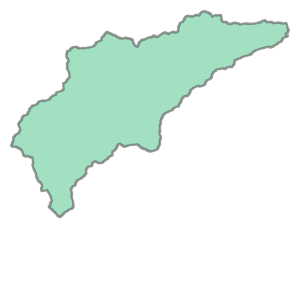

In [16]:
bounds = watershed.exterior()
bounds

## Download

In [17]:
startdate = "1-1980"
enddate = "365-2020"

**returned raw data is in (nband, nrow, ncol)**

In [18]:
raw, x, y = workflow.daymet.collectDaymet( bounds, start = startdate, end = enddate,  crs = crs)

2021-06-24 23:13:12,099 - root - INFO: downloading variables: ['tmin', 'tmax', 'prcp', 'srad', 'vp', 'swe', 'dayl']
2021-06-24 23:13:12,476 - root - INFO: Collecting DayMet file to tile bounds: [-121.53265735527542, 46.80083675067209, -121.15866718696076, 47.002969147236286]
2021-06-24 23:13:12,480 - root - INFO:   Using existing: /Users/shua784/github/yakima/data/meteorology/daymet/daymet_tmin_1980_47.002969147236286x-121.53265735527542_46.80083675067209x-121.15866718696076.nc
2021-06-24 23:13:12,933 - root - INFO: Collecting DayMet file to tile bounds: [-121.53265735527542, 46.80083675067209, -121.15866718696076, 47.002969147236286]
2021-06-24 23:13:12,935 - root - INFO:   Using existing: /Users/shua784/github/yakima/data/meteorology/daymet/daymet_tmax_1980_47.002969147236286x-121.53265735527542_46.80083675067209x-121.15866718696076.nc
2021-06-24 23:13:13,274 - root - INFO: Collecting DayMet file to tile bounds: [-121.53265735527542, 46.80083675067209, -121.15866718696076, 47.0029691

## Convert Daymet CRS

- Daymet has to be in the same CRS as the meshes (e.g., epsg: 2856)
- default conversion set nodata = 0, this should be ok if the daymet covers a much larger area of the watershed. **Care should be taken if daymet coverage is very close to watershed boundary**
- some difference is observed in the converted daymet, maybe caused by the large pixal size (1km). Smaller pixal (set `resolution < 1km` will better preserve the raw data during reprojection.

In [9]:
new_x, new_y, new_extent, new_dat, daymet_profile = workflow.daymet.reproj_Daymet(x, y, raw,  dst_crs = crs)

2021-06-18 11:09:08,659 - root - INFO: daymet profile: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 32, 'height': 28, 'count': 14965, 'crs': CRS.from_wkt('PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",42.5],PARAMETER["central_meridian",-100],PARAMETER["standard_parallel_1",25],PARAMETER["standard_parallel_2",60],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(1000.0, 0.0, -1552750.0,
       0.0, -1000.0, 678500.0), 'tiled': False, 'interleave': 'pixel'}
2021-06-18 11:09:08,660 - root - INFO: reprojecting to new crs: EPSG:2856
2021-06-18 11:09:13,548 - root - INFO: new profi

## plot new Daymet

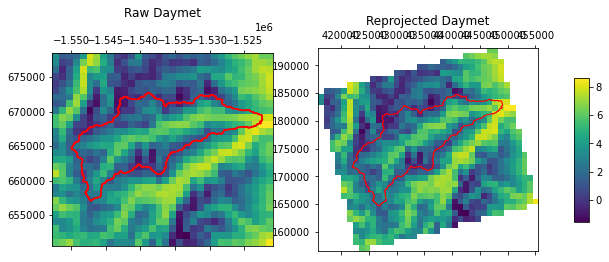

In [10]:
ivar = 'tmax'
islice = 100
fig, axes = plt.subplots(1, 2, figsize=(10,4))

ax = axes[0]
extent = rasterio.transform.array_bounds(daymet_profile['height'], daymet_profile['width'], daymet_profile['transform']) # (x0, y0, x1, y1)
plot_extent = extent[0], extent[2], extent[1], extent[3]

iraster = raw[ivar][islice, :, :]

with fiona.open(watershed_shapefile, mode='r') as fid:
    bnd_profile = fid.profile
    bnd = [r for (i,r) in fid.items()]
daymet_crs = workflow.crs.daymet_crs()

# convert to destination crs
native_crs = workflow.crs.from_fiona(bnd_profile['crs'])
reproj_bnd = workflow.warp.shape(bnd[0], native_crs, daymet_crs)
reproj_bnd_shply = workflow.utils.shply(reproj_bnd)

cax = ax.matshow(iraster, extent=plot_extent, alpha=1)
ax.plot(*reproj_bnd_shply.exterior.xy, 'r')
ax.set_title("Raw Daymet")


ax = axes[1]
extent = new_extent # (x0, y0, x1, y1)
plot_extent = extent[0], extent[2], extent[1], extent[3] # (x0, x1, y0, y1)

iraster = new_dat[ivar][islice, :, :]

# set nodata to NaN to avoid plotting
iraster[iraster == -9999] = np.nan

workflow.plot.hucs(watershed, crs, ax=ax, color='r', linewidth=1)
im = ax.matshow(iraster, extent=plot_extent)
ax.set_title("Reprojected Daymet")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
fig.colorbar(im, cax=cbar_ax)

## Write to ATS format

This will write daymet in a format that ATS can read. E.g., this will partition precipitation into rain and snow, convert vapor pressure to relative humidity, get mean air temperature and so on.

- dout has dims of `(ntime, nrow, ncol)` or `(ntime, ny, nx)`

In [11]:
time, dout = workflow.daymet.writeATS(new_dat, new_x, new_y, 
                         workflow.daymet.getAttrs(bounds.bounds, startdate, enddate), 
                         fname_daymet_h5)

2021-06-18 11:09:21,361 - root - INFO: Writing ATS file: ./data/daymet/American_daymet_1980-2020.h5
2021-06-18 11:09:21,368 - root - INFO: input dat shape: (14965, 35, 38)
2021-06-18 11:09:21,368 - root - INFO: Converting to ATS met input
